In [272]:
from ocr import OCR
from PIL import Image
import cv2
import os
import keras_ocr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob as glob
import openpyxl as op
import re
from joblib import Parallel, delayed
import joblib
import uuid
import keras_ocr
import easyocr
import plotly.express as px
import pytesseract

def flatten(l):
    return [item for sublist in l for item in sublist]
def extract_score(text):
    match = re.search(r'(\d+)/(\d+)', text)
    if match:
        return match.group(0)
    return None


# Dictionary crops

In [273]:
crops={
    'densities':{},
    'faz':{}
      }
crops['densities']['table_top_left']={
                                'l' : 1530,
                                't' : 154,
                                'r' : 1600,
                                'b' : 540
                                }
crops['densities']['table_top_right']={
                                'l' : 1750,
                                't' : 154,
                                'r' : 1825,
                                'b' : 540
                                }
crops['densities']['table_bot']={
                                'l' : 1535,
                                't' : 560,
                                'r' : 1825,
                                'b' : 630
                                }
crops['densities']['quality']={
                                'l' : 1116,
                                't' : 55,
                                'r' : 1200,
                                'b' : 100
                                }
crops['faz']['values']={
                            'l' : 400,
                            't' : 90,
                            'r' : 800,
                            'b' : 125
                            }


crops['faz']['quality']={
                        'l' : 1116,
                        't' : 55,
                        'r' : 1200,
                        'b' : 100
                        }
shift=232

# FILES

In [274]:
#first iteration
folders_patients=glob('../data/NOPAIN_OCTA/P*')
folders_visits=glob('../data/NOPAIN_OCTA//P*/V*')
visits=sorted(
    list(
        set([folder.split("/")[4] for folder in folders_visits])
    )
)
patients=sorted(
    list(
        set([folder.split('/')[3] for folder in folders_patients]) 
    )
)
# patients
# visits

#Calm down here
# imgs={}
# for patient in patients:
#     imgs[patient]={}
#     files=glob('../data/'+patient+"/*/*")
#     files=[file for file in files if 'Zone' not in file]
#     densities=[file for file in files if ('Density' in file) ]
#     fazs=[file for file in files if ('FAZ' in file)  ]
#     imgs[patient]['densities']=densities
#     imgs[patient]['fazs']=fazs


In [275]:
#second iteration
files=glob('../data/NOPAIN_OCTA//*/*/*png')
files=[file for file in files if 'QuickVue' not in file]
# files=[file for file in files if ('Extra' not in file) and ('Additional' not in file)]
imgpervisit={}
for visit in visits:
    imgpervisit[visit]=sorted([file for file in files if visit in file])



## CHOOSE TARGETS

In [276]:
files=[file for file in files if ('Extra' not in file) and ('Additional' not in file) and ('(2)' not in file)]

In [277]:
files=[file for file in files if 'Density.png' not in file]
files=sorted(files)
files

['../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 3.0 - Density DP.png',
 '../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 3.0 - Density SUP.png',
 '../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 3.0 - FAZ.png',
 '../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 6.0 - Density DP.png',
 '../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 6.0 - Density SUP.png',
 '../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 6.0 - FAZ.png',
 '../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 3.0 - Density DP.png',
 '../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 3.0 - Density SUP.png',
 '../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 3.0 - FAZ.png',
 '../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 6.0 - Density DP.png',
 '../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 6.0 - Density SUP.png',
 '../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 6.0 - FAZ.png',
 '../data/NOPAIN_OCTA/P001/V3/P001, R eye, V3, 3.0 - Density DP.png',
 '../data/NOPAIN_OCTA/P001/V3/P001, R eye, V3, 3.0 - Density SUP.png',
 '../data/NOPAIN_OCTA/P001/V3/P001, R eye, 

In [14]:
# doubles=[ file for file in files if '(2)' in file]
# check=[]
# for i in doubles:
#     check.append([ file for file in files if i[0:30]  in file])
# check

# SERIAL ALGO 

In [ ]:
%%time
cols=[
 'QUALITY',
 'depth_whole',
 'depth_sup hemi',
 'depth_inf hemi',
 'depth_fovea',
 'depth_parafovea',
 'depth_para_sup hemi',
 'depth_parai_inf hemi',
 'depth_para temp',
 'depth_para_sup',
 'depth_para_nasal',
 'depth_para_inf',
 'depth_perifovea',
 'depth_peri_sup hemi',
 'depth_peri_inf hemi',
 'depth_peri_tempo ',
 'depth_peri_sup',
 'depth_peri_nasal',
 'depth_peri_inf',
 'thick_whole',
 'thick_sup hemi',
 'thick_inf hemi',
 'thick_fovea',
 'thick_parafovea',
 'thick_para_sup hemi',
 'thick_parai_inf hemi',
 'thick_para temp',
 'thick_para_sup',
 'thick_para_nasal',
 'thick_para_inf',
 'thick_perifovea',
 'thick_peri_sup hemi',
 'thick_peri_inf hemi',
 'thick_peri_tempo ',
 'thick_peri_sup',
 'thick_peri_nasal',
 'thick_peri_inf',
 'grid_v_d1',
 'grid_v_d2',
 'grid_v_d3',
 'grid_v_d4',
 'grid_v_d5',
 'grid_v_d6',
 'grid_v_d7',
 'grid_v_d8',
 'grid_v_d9',
 'area (mm2)',
 'perim (mm)',
 'FD']

errors_top=[]
errors_bot=[]
errors_qual=[]
error_faz=[]

df=pd.DataFrame(columns=['pat','v','eye','depth']+cols) # MAKE THE COLUMNS, cols come from readin the sheet.
for file in files:
    unique_id=uuid.uuid4()
    df=pd.DataFrame(columns=['pat','v','eye','depth']+cols) # MAKE THE COLUMNS, cols come from readin the sheet.

    print(file)
    pat=file.split('/')[2]
    v=file.split('/')[3]
    eye=file.split(',')[1].strip()
    depth=file.split(',')[3].split('-')[0].strip()
    unique_id=f"{pat}_{v}_{eye}_{depth}"+str(uuid.uuid4())
    os.mkdir(f'evaluate/{unique_id}')
#     fdelete = glob('evaluate/*')
#     for f in fdelete:
#         os.remove(f)
    if 'Density' in file:
        specification='SUP' if 'SUP' in file else 'DP'
        im = Image.open(file)

        cropped_top1= im.crop((crops['densities']['table_top_left']['l'],
                              crops['densities']['table_top_left']['t'],
                              crops['densities']['table_top_left']['r'],
                              crops['densities']['table_top_left']['b']))
        cropped_top2= im.crop((crops['densities']['table_top_right']['l'],
                              crops['densities']['table_top_right']['t'],
                              crops['densities']['table_top_right']['r'],
                              crops['densities']['table_top_right']['b']))
        
        cropped_bot= im.crop((crops['densities']['table_bot']['l'],
                              crops['densities']['table_bot']['t'],
                              crops['densities']['table_bot']['r'],
                              crops['densities']['table_bot']['b']))
        cropped_qual= im.crop((crops['densities']['quality']['l'],
                               crops['densities']['quality']['t'],
                               crops['densities']['quality']['r'],
                               crops['densities']['quality']['b']))
        cropped_top1.save(f'evaluate/{unique_id}/a_cropped_top1.png')
        cropped_top2.save(f'evaluate/{unique_id}/b_cropped_top2.png')
        cropped_qual.save(f'evaluate/{unique_id}/c_cropped_quality.png')
        cropped_bot.save(f'evaluate/{unique_id}/d_cropped_bot.png')
        
        ocr=OCR(image_folder=f"evaluate/{unique_id}/")
        results=ocr.easyocr_model_works(visualization=False)  
        temp={   'QUALITY': np.nan,
                 'depth_whole': np.nan,
                 'depth_sup hemi': np.nan,
                 'depth_inf hemi': np.nan,
                 'depth_fovea': np.nan,
                 'depth_parafovea': np.nan,
                 'depth_para_sup hemi': np.nan,
                 'depth_parai_inf hemi': np.nan,
                 'depth_para temp': np.nan,
                 'depth_para_sup': np.nan,
                 'depth_para_nasal': np.nan,
                 'depth_para_inf': np.nan,
                 'depth_perifovea': np.nan,
                 'depth_peri_sup hemi': np.nan,
                 'depth_peri_inf hemi': np.nan,
                 'depth_peri_tempo ': np.nan,
                 'depth_peri_sup': np.nan,
                 'depth_peri_nasal': np.nan,
                 'depth_peri_inf': np.nan,
                 'thick_whole': np.nan,
                 'thick_sup hemi': np.nan,
                 'thick_inf hemi': np.nan,
                 'thick_fovea': np.nan,
                 'thick_parafovea': np.nan,
                 'thick_para_sup hemi': np.nan,
                 'thick_parai_inf hemi': np.nan,
                 'thick_para temp': np.nan,
                 'thick_para_sup': np.nan,
                 'thick_para_nasal': np.nan,
                 'thick_para_inf': np.nan,
                 'thick_perifovea': np.nan,
                 'thick_peri_sup hemi': np.nan,
                 'thick_peri_inf hemi': np.nan,
                 'thick_peri_tempo ': np.nan,
                 'thick_peri_sup': np.nan,
                 'thick_peri_nasal': np.nan,
                 'thick_peri_inf': np.nan,
                 'grid_v_d1': np.nan,
                 'grid_v_d2': np.nan,
                 'grid_v_d3': np.nan,
                 'grid_v_d4': np.nan,
                 'grid_v_d5': np.nan,
                 'grid_v_d6': np.nan,
                 'grid_v_d7': np.nan,
                 'grid_v_d8': np.nan,
                 'grid_v_d9':np.nan
                }
##################################################################################QUALITY
        try:
            qual=results[2][0][1]
            temp[list(temp.keys())[0]]=qual
        except Exception as e:
            errors_qual.append(['quality_error in',file,e,])
            cropped_top1= im.crop((crops['densities']['table_top_left']['l'],
                                  crops['densities']['table_top_left']['t']+215,
                                  crops['densities']['table_top_left']['r'],
                                  crops['densities']['table_top_left']['b']+215))
            cropped_top2= im.crop((crops['densities']['table_top_right']['l'],
                                  crops['densities']['table_top_right']['t']+215,
                                  crops['densities']['table_top_right']['r'],
                                  crops['densities']['table_top_right']['b']+215))

            cropped_bot= im.crop((crops['densities']['table_bot']['l'],
                                  crops['densities']['table_bot']['t']+215,
                                  crops['densities']['table_bot']['r'],
                                  crops['densities']['table_bot']['b']+215))
            cropped_qual= im.crop((crops['densities']['quality']['l'],
                                   crops['densities']['quality']['t']+215,
                                   crops['densities']['quality']['r'],
                                   crops['densities']['quality']['b']+215))
            fdelete = glob(f'evaluate/{unique_id}/*')
            for f in fdelete:
                os.remove(f)
            cropped_top1.save(f'evaluate/{unique_id}/a_cropped_top1.png')
            cropped_top2.save(f'evaluate/{unique_id}/b_cropped_top2.png')
            cropped_qual.save(f'evaluate/{unique_id}/c_cropped_quality.png')
            cropped_bot.save(f'evaluate/{unique_id}/d_cropped_bot.png')
            ocr=OCR(image_folder=f"evaluate/{unique_id}/")
            results=ocr.easyocr_model_works(visualization=False)  
            try:
                qual=results[2][0][1]
                temp[list(temp.keys())[0]]=qual
            except Exception as ee:
                errors_qual.append(['Definite quality error in ',file,ee])
##################################################################################TABLE TOP
        try:
            data_2d=zip(np.array(results[0],dtype=object)[:,1],np.array(results[1],dtype=object)[:,1])
            df_top=pd.DataFrame(data_2d)
            for i,val in enumerate(df_top[0].values,start=1):
                temp[list(temp.keys())[i]]=val
            for i,val in enumerate(df_top[1].values,start=19):
                temp[list(temp.keys())[i]]=val
        except Exception as e:
            errors_top.append(['top_error in',file,e])
            
##################################################################################TABLE BOT
        data_lin=np.array(results[3],dtype=object)[:,1]
        try:
            data_2d=np.split(data_lin,data_lin.shape[0]/3)
            df_bot=pd.DataFrame(data_2d)
            df_bot_list=flatten(df_bot.values.tolist())
            for i,val in enumerate(df_bot_list,start=37):
                temp[list(temp.keys())[i]]=val
            temp['pat']  = pat
            temp['v']    = v
            temp['eye']  = eye
            temp['depth']= depth
            temp['specification']=specification
            df=df.append(
                temp,
                ignore_index=True)
        except Exception as e:
            errors_bot.append(['bot_error in',file,e])
#####################################################################
#####################################################################  FAZ
#####################################################################
    elif 'FAZ' in file:
        specification='FAZ'
        im = Image.open(file)
        cropped_values= im.crop((crops['faz']['values']['l'],
                                 crops['faz']['values']['t'],
                                 crops['faz']['values']['r'],
                                 crops['faz']['values']['b']))

        cropped_qual= im.crop((crops['faz']['quality']['l'],
                               crops['faz']['quality']['t'],
                               crops['faz']['quality']['r'],
                               crops['faz']['quality']['b']))
        cropped_values.save(f'evaluate/{unique_id}/a_cropped_values.png')
        cropped_qual.save(f'evaluate/{unique_id}/b_cropped_quality.png')
        ocr=OCR(image_folder=f"evaluate/{unique_id}/")
        results=ocr.easyocr_model_works(visualization=False)
        try:
            temp=string=' '.join([result[1] for result in results[0]]) #extracting all the ugly strings from OCR for first 3 values
            clean_3=re.findall(r"[-+]?(?:\d*\.\d+|\d+)", temp)         #regex to extract only the numbers
            last=string=' '.join([result[1] for result in results[1]]) #extract quality
            if type(last) is not list:
                last=[last]
            res_clean=clean_3+last

            df=df.append({
                'pat':pat,
                'v':v,
                'eye':eye,
                'depth':depth,
                'area (mm2)':res_clean[0],
                'perim (mm)':res_clean[1],
                'FD':res_clean[2],
                'QUALITY':res_clean[-1],
                'specification':specification
            },
            ignore_index=True)
        except Exception as e:
            error_faz.append(['quality_error in',file,e])


## JOBLIB

In [7]:
file=files[127]
print(file)
pat=file.split('/')[3]
v=file.split('/')[4]
eye=file.split(',')[1].strip()
depth=file.split(',')[3].split('-')[0].strip()
pat,v,eye,depth

../data/NOPAIN_OCTA/P009/V3/P009, L eye, V3, 6.0 - Density SUP.png


('P009', 'V3', 'L eye', '6.0')

In [278]:
%%time
cols=[
 'QUALITY',
 'depth_whole',
 'depth_sup hemi',
 'depth_inf hemi',
 'depth_fovea',
 'depth_parafovea',
 'depth_para_sup hemi',
 'depth_parai_inf hemi',
 'depth_para temp',
 'depth_para_sup',
 'depth_para_nasal',
 'depth_para_inf',
 'depth_perifovea',
 'depth_peri_sup hemi',
 'depth_peri_inf hemi',
 'depth_peri_tempo ',
 'depth_peri_sup',
 'depth_peri_nasal',
 'depth_peri_inf',
 'thick_whole',
 'thick_sup hemi',
 'thick_inf hemi',
 'thick_fovea',
 'thick_parafovea',
 'thick_para_sup hemi',
 'thick_parai_inf hemi',
 'thick_para temp',
 'thick_para_sup',
 'thick_para_nasal',
 'thick_para_inf',
 'thick_perifovea',
 'thick_peri_sup hemi',
 'thick_peri_inf hemi',
 'thick_peri_tempo ',
 'thick_peri_sup',
 'thick_peri_nasal',
 'thick_peri_inf',
 'grid_v_d1',
 'grid_v_d2',
 'grid_v_d3',
 'grid_v_d4',
 'grid_v_d5',
 'grid_v_d6',
 'grid_v_d7',
 'grid_v_d8',
 'grid_v_d9',
 'area (mm2)',
 'perim (mm)',
 'FD']

errors_top=[]
errors_bot=[]
errors_qual=[]
error_faz=[]

    
def extract(file):    
    bs=20
    unique_id=uuid.uuid4()
    df=pd.DataFrame(columns=['pat','v','eye','depth']+cols) # MAKE THE COLUMNS, cols come from readin the sheet.
    print(file)
    pat=file.split('/')[3]
    v=file.split('/')[4]
    eye=file.split(',')[1].strip()
    depth=file.split(',')[3].split('-')[0].strip()
    unique_id=f"{pat}_{v}_{eye}_{depth}"+str(uuid.uuid4())
    os.mkdir(f'evaluate/{unique_id}')
#     fdelete = glob('evaluate/*')
#     for f in fdelete:
#         os.remove(f)
    if 'Density' in file:
        specification='SUP' if 'SUP' in file else 'DP'
        im = Image.open(file)
        #CROP IMAGE
        cropped_top1= im.crop((crops['densities']['table_top_left']['l'],
                              crops['densities']['table_top_left']['t'],
                              crops['densities']['table_top_left']['r'],
                              crops['densities']['table_top_left']['b']))
        cropped_top2= im.crop((crops['densities']['table_top_right']['l'],
                              crops['densities']['table_top_right']['t'],
                              crops['densities']['table_top_right']['r'],
                              crops['densities']['table_top_right']['b']))
        
        cropped_bot= im.crop((crops['densities']['table_bot']['l'],
                              crops['densities']['table_bot']['t'],
                              crops['densities']['table_bot']['r'],
                              crops['densities']['table_bot']['b']))
        cropped_qual= im.crop((crops['densities']['quality']['l'],
                               crops['densities']['quality']['t'],
                               crops['densities']['quality']['r'],
                               crops['densities']['quality']['b']))
        
        cropped_top1.save(f'evaluate/{unique_id}/a_cropped_top1.png')
        cropped_top2.save(f'evaluate/{unique_id}/b_cropped_top2.png')
        cropped_qual.save(f'evaluate/{unique_id}/c_cropped_quality.png')
        cropped_bot.save(f'evaluate/{unique_id}/d_cropped_bot.png')
        
        #OCR
        ocr=OCR(image_folder=f"evaluate/{unique_id}/")
        results=ocr.easyocr_model_works(visualization=False,batch_size=bs)  
        
        if (len(results[0])<19 and len(results[0])>17) and (len(results[0])==len(results[1]) ):
            pass
        else:
            print("PESKY IMAGE")
            print('len of results[0] is',len(results[0]))
            print('len of results[1] is',len(results[1]))
            print('len of results[2] is',len(results[2]))
            print('len of results[3] is',len(results[3]))
            shift=232
            cropped_top1= im.crop((crops['densities']['table_top_left']['l'],
                                  crops['densities']['table_top_left']['t']+shift,
                                  crops['densities']['table_top_left']['r'],
                                  crops['densities']['table_top_left']['b']+shift))
            cropped_top2= im.crop((crops['densities']['table_top_right']['l'],
                                  crops['densities']['table_top_right']['t']+shift,
                                  crops['densities']['table_top_right']['r'],
                                  crops['densities']['table_top_right']['b']+shift))

            cropped_bot= im.crop((crops['densities']['table_bot']['l'],
                                  crops['densities']['table_bot']['t']+shift,
                                  crops['densities']['table_bot']['r'],
                                  crops['densities']['table_bot']['b']+shift))
            cropped_qual= im.crop((crops['densities']['quality']['l'],
                                   crops['densities']['quality']['t']+shift,
                                   crops['densities']['quality']['r'],
                                   crops['densities']['quality']['b']+shift))
            fdelete = glob(f'evaluate/{unique_id}/*')
            for f in fdelete:
                os.remove(f)
            cropped_top1.save(f'evaluate/{unique_id}/a_cropped_top1.png')
            cropped_top2.save(f'evaluate/{unique_id}/b_cropped_top2.png')
            cropped_qual.save(f'evaluate/{unique_id}/c_cropped_quality.png')
            cropped_bot.save(f'evaluate/{unique_id}/d_cropped_bot.png')
            ocr=OCR(image_folder=f"evaluate/{unique_id}/")
            results=ocr.easyocr_model_works(visualization=False,batch_size=bs)  
#             results=ocr.easyocr_model_works(visualization=True)  
        
        ######
        temp={   'QUALITY': np.nan,
                 'depth_whole': np.nan,
                 'depth_sup hemi': np.nan,
                 'depth_inf hemi': np.nan,
                 'depth_fovea': np.nan,
                 'depth_parafovea': np.nan,
                 'depth_para_sup hemi': np.nan,
                 'depth_parai_inf hemi': np.nan,
                 'depth_para temp': np.nan,
                 'depth_para_sup': np.nan,
                 'depth_para_nasal': np.nan,
                 'depth_para_inf': np.nan,
                 'depth_perifovea': np.nan,
                 'depth_peri_sup hemi': np.nan,
                 'depth_peri_inf hemi': np.nan,
                 'depth_peri_tempo ': np.nan,
                 'depth_peri_sup': np.nan,
                 'depth_peri_nasal': np.nan,
                 'depth_peri_inf': np.nan,
                 'thick_whole': np.nan,
                 'thick_sup hemi': np.nan,
                 'thick_inf hemi': np.nan,
                 'thick_fovea': np.nan,
                 'thick_parafovea': np.nan,
                 'thick_para_sup hemi': np.nan,
                 'thick_parai_inf hemi': np.nan,
                 'thick_para temp': np.nan,
                 'thick_para_sup': np.nan,
                 'thick_para_nasal': np.nan,
                 'thick_para_inf': np.nan,
                 'thick_perifovea': np.nan,
                 'thick_peri_sup hemi': np.nan,
                 'thick_peri_inf hemi': np.nan,
                 'thick_peri_tempo ': np.nan,
                 'thick_peri_sup': np.nan,
                 'thick_peri_nasal': np.nan,
                 'thick_peri_inf': np.nan,
                 'grid_v_d1': np.nan,
                 'grid_v_d2': np.nan,
                 'grid_v_d3': np.nan,
                 'grid_v_d4': np.nan,
                 'grid_v_d5': np.nan,
                 'grid_v_d6': np.nan,
                 'grid_v_d7': np.nan,
                 'grid_v_d8': np.nan,
                 'grid_v_d9':np.nan
                }
        
##################################################################################TABLE TOP
        try:
            data_2d=zip(np.array(results[0],dtype=object)[:,1],np.array(results[1],dtype=object)[:,1])
            df_top=pd.DataFrame(data_2d)
            for i,val in enumerate(df_top[0].values,start=1):
                temp[list(temp.keys())[i]]=val
            for i,val in enumerate(df_top[1].values,start=19):
                temp[list(temp.keys())[i]]=val
        except Exception as e:
            errors_top.append(['top_error in',file,e])
            
##################################################################################TABLE BOT
        data_lin=np.array(results[3],dtype=object)[:,1]
        try:
            data_2d=np.split(data_lin,data_lin.shape[0]/3)
            df_bot=pd.DataFrame(data_2d)
            df_bot_list=flatten(df_bot.values.tolist())
            for i,val in enumerate(df_bot_list,start=37):
                temp[list(temp.keys())[i]]=val
        except Exception as e:
            errors_bot.append(['bot_error in',file,e])
            
##################################################################################QUALITY
        try:
            qual=results[2][0][1]
#             print('len of results[0] is',len(results[0]))
#             print('len of results[1] is',len(results[1]))
#             print('len of results[2] is',len(results[2]))
#             print('len of results[3] is',len(results[3]))
            temp[list(temp.keys())[0]]=qual
        except Exception as e:
            errors_qual.append(['quality_error in',file,e,])
            
        try:
            temp['pat']  = pat
            temp['v']    = v
            temp['eye']  = eye
            temp['depth']= depth
            temp['specification']=specification
            df=df.append(
                temp,
                ignore_index=True)
        except:
            print('error compiling the df')
#             cropped_top1= im.crop((crops['densities']['table_top_left']['l'],
#                                   crops['densities']['table_top_left']['t']+shift,
#                                   crops['densities']['table_top_left']['r'],
#                                   crops['densities']['table_top_left']['b']+shift))
#             cropped_top2= im.crop((crops['densities']['table_top_right']['l'],
#                                   crops['densities']['table_top_right']['t']+shift,
#                                   crops['densities']['table_top_right']['r'],
#                                   crops['densities']['table_top_right']['b']+shift))

#             cropped_bot= im.crop((crops['densities']['table_bot']['l'],
#                                   crops['densities']['table_bot']['t']+shift,
#                                   crops['densities']['table_bot']['r'],
#                                   crops['densities']['table_bot']['b']+shift))
#             cropped_qual= im.crop((crops['densities']['quality']['l'],
#                                    crops['densities']['quality']['t']+shift,
#                                    crops['densities']['quality']['r'],
#                                    crops['densities']['quality']['b']+shift))
#             fdelete = glob(f'evaluate/{unique_id}/*')
#             for f in fdelete:
#                 os.remove(f)
#             cropped_top1.save(f'evaluate/{unique_id}/a_cropped_top1.png')
#             cropped_top2.save(f'evaluate/{unique_id}/b_cropped_top2.png')
#             cropped_qual.save(f'evaluate/{unique_id}/c_cropped_quality.png')
#             cropped_bot.save(f'evaluate/{unique_id}/d_cropped_bot.png')
#             ocr=OCR(image_folder=f"evaluate/{unique_id}/")
#             results=ocr.easyocr_model_works(visualization=False)  
#             try:
#                 qual=results[2][0][1]
#                 print('second loop',qual)
#                 temp[list(temp.keys())[0]]=qual
#             except Exception as ee:
#                 errors_qual.append(['Definite quality error in ',file,ee])
                

#####################################################################
#####################################################################  FAZ
#####################################################################
    elif 'FAZ' in file:
        specification='FAZ'
        im = Image.open(file)
        cropped_values= im.crop((crops['faz']['values']['l'],
                                 crops['faz']['values']['t'],
                                 crops['faz']['values']['r'],
                                 crops['faz']['values']['b']))

        cropped_qual= im.crop((crops['faz']['quality']['l'],
                               crops['faz']['quality']['t'],
                               crops['faz']['quality']['r'],
                               crops['faz']['quality']['b']))
        cropped_values.save(f'evaluate/{unique_id}/a_cropped_values.png')
        cropped_qual.save(f'evaluate/{unique_id}/b_cropped_quality.png')
        ocr=OCR(image_folder=f"evaluate/{unique_id}/")
        results=ocr.easyocr_model_works(visualization=False,batch_size=bs)
        try:
            temp=string=' '.join([result[1] for result in results[0]]) #extracting all the ugly strings from OCR for first 3 values
            clean_3=re.findall(r"[-+]?(?:\d*\.\d+|\d+)", temp)         #regex to extract only the numbers
            last=string=' '.join([result[1] for result in results[1]]) #extract quality
            if type(last) is not list:
                last=[last]
            res_clean=clean_3+last

            df=df.append({
                'pat':pat,
                'v':v,
                'eye':eye,
                'depth':depth,
                'area (mm2)':res_clean[0],
                'perim (mm)':res_clean[1],
                'FD':res_clean[2],
                'QUALITY':res_clean[-1],
                'specification':specification
            },
            ignore_index=True)
        except Exception as e:
            error_faz.append(['quality_error in',file,e])
    return df

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


## COMPUTE 

In [279]:
%%time
# temp_to_200=Parallel(n_jobs=-1)(delayed(extract)(file)for file in files[20:25])
temp_to_200=Parallel(n_jobs=-1)(delayed(extract)(file)for file in files[:100])

2023-02-08 07:25:15.413152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 07:25:15.560059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 07:25:15.575867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2023-02-08 07:25:16.484199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/home/ubuntu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-08 07:25:16.484267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/home/ubuntu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-08 07:25:16.484272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make 

2023-02-08 07:25:19.741134: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-08 07:25:19.741186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubp): /proc/driver/nvidia/version does not exist
2023-02-08 07:25:19.741742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 07:25:19.756227: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-08 07:25:19.756275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] k

2023-02-08 07:25:20.736975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-08 07:25:20.737027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubp): /proc/driver/nvidia/version does not exist
2023-02-08 07:25:20.737602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 07:25:20.859075: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-08 07:25:20.859149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] k

<timed exec>:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
<timed exec>:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:228: FutureWarning: The frame.append method is deprecated and 

../data/NOPAIN_OCTA/P001/V3/P001, R eye, V3, 3.0 - FAZ.png
Looking for /home/ubuntu/.keras-ocr/craft_mlt_25k.h5
Looking for /home/ubuntu/.keras-ocr/crnn_kurapan.h5
../data/NOPAIN_OCTA/P002/V2/P002, L eye, V2, 3.0 - FAZ.png
Looking for /home/ubuntu/.keras-ocr/craft_mlt_25k.h5
Looking for /home/ubuntu/.keras-ocr/crnn_kurapan.h5
../data/NOPAIN_OCTA/P002/V3/P002, R eye, V3, 3.0 - Density DP.png
Looking for /home/ubuntu/.keras-ocr/craft_mlt_25k.h5
Looking for /home/ubuntu/.keras-ocr/crnn_kurapan.h5


<timed exec>:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
<timed exec>:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
CUDA not 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [280]:
temp

NameError: name 'temp_to_200' is not defined

## DEBUG

In [259]:
#FIND ONLY DENSITIES
idx_dens=[]
for i,file in enumerate(files):
    if 'Density' in file:
        print(i,file)
        idx_dens.append(i)

0 ../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 3.0 - Density DP.png
1 ../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 3.0 - Density SUP.png
3 ../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 6.0 - Density DP.png
4 ../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 6.0 - Density SUP.png
6 ../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 3.0 - Density DP.png
7 ../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 3.0 - Density SUP.png
9 ../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 6.0 - Density DP.png
10 ../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 6.0 - Density SUP.png
12 ../data/NOPAIN_OCTA/P001/V3/P001, R eye, V3, 3.0 - Density DP.png
13 ../data/NOPAIN_OCTA/P001/V3/P001, R eye, V3, 3.0 - Density SUP.png
15 ../data/NOPAIN_OCTA/P001/V3/P001, R eye, V3, 6.0 - Density DP.png
16 ../data/NOPAIN_OCTA/P001/V3/P001, R eye, V3, 6.0 - Density SUP.png
18 ../data/NOPAIN_OCTA/P002/V2/P002, L eye, V2, 3.0 - Density DP.png
19 ../data/NOPAIN_OCTA/P002/V2/P002, L eye, V2, 3.0 - Density SUP.png
21 ../data/NOPAIN_OCTA/P002/V2/P00

In [507]:
def assess_errors_tess(idx,zone,shift=0):
#     unique_id=uuid.uuid4()
#     os.mkdir(f'debug/{unique_id}')
    im=Image.open(files[idx])
    crop_dict=crops['densities'][zone]
    cropped = im.crop((crop_dict['l'],
                       crop_dict['t']+shift,
                       crop_dict['r'],
                       crop_dict['b']+shift))
#     cropped.save(f'debug/cropped{idx}.png')
#     im=cv2.imread(f'debug/cropped{idx}.png')
    im=np.array(cropped)
    
#     #TESSERACT
    ocr_tess=pytesseract.image_to_string(im,config ='--psm 6')
    ocr_tess=ocr_tess.replace('.','').replace(',','').replace('S','5')
    lst_tess=ocr_tess.replace('\x0c','').split('\n')[:-1]
    lst_tess=[elem[0:2]+'.'+elem[2:]  if isfloat(elem) else elem for elem in lst_tess]
    
#     return idx,results_eocr,ocr_tess
    return idx,lst_tess,len(lst_tess)


def assess_errors_eor(idx,shift=0):
#     unique_id=uuid.uuid4()
#     os.mkdir(f'debug/{unique_id}')
    im=Image.open(files[idx])
    crop_dict=crops['densities']['table_top_right']
    cropped = im.crop((crop_dict['l'],
                       crop_dict['t']+shift,
                       crop_dict['r'],
                       crop_dict['b']+shift))
#     cropped.save(f'debug/cropped{idx}.png')
#     im=cv2.imread(f'debug/cropped{idx}.png')
    im=np.array(cropped)
    
#    EASYOCR
    reader=easyocr.Reader(['en'])
    results_eocr=reader.readtext(im,batch_size=20)
    list_results_eocr=[result[1] for result in results_eocr]
    
    ocr_eor=[ elem.replace('.','').replace(',','') for elem in list_results_eocr]
    lst_eor=[ elem.replace('NJA','N/A') for elem in ocr_eor]
    lst_eor_clean=[elem[0:2]+'.'+elem[2:]  if isfloat(elem) else elem for elem in lst_eor]
    
    return idx,lst_eor_clean,len(list_results_eocr)


In [467]:
%%time
# tess=Parallel(n_jobs=-1)(delayed(assess_errors_tess)(idx)for idx in range(100))
tess=[]
for idx in idx_dens[:100]:
    tess.append(assess_errors_tess(idx,'table_top_left'))

CPU times: user 2.96 s, sys: 3.14 s, total: 6.09 s
Wall time: 22 s


In [468]:
%%time
eor=Parallel(n_jobs=-1)(delayed(assess_errors_eor)(idx)for idx in idx_dens[:100])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CPU times: user 681 ms, sys: 655 ms, total: 1.34 s
Wall time: 25.1 s


In [469]:
#TESSERACT VS EASYOCR
probs=[]
count=0
goods=[]
tesswin=[]
eorwin=[]
pure_errors=[]

for i in range(100):
    file_idx=tess[i][0]
    list_eor=eor[i][1]
    list_tesseract=tess[i][1]
    len_eor=len(list_eor)
    len_tess=len(list_tesseract)
    if len_eor == len_tess and len_tess==18 :
#         probs.append([file_idx,len_eor-len_tess,len(list_eor),len(list_tesseract)])
        goods.append([file_idx,list(zip(list_eor,list_tesseract))])
        count+=1
    elif len_eor!=18 and len_tess==18:
        print('tesswin')
        tesswin.append([file_idx,list_eor,list_tesseract])
    elif len_eor==18 and len_tess !=18:
        print('eorwin')
        eorwin.append([file_idx,list_eor,list_tesseract])
    elif len_eor !=18 and len_tess != 18:
        pure_errors.append([file_idx,list(zip(list_eor,list_tesseract))])
print("good counts= ",count)
idx_f2=[ elem[0] for elem in pure_errors]

tesswin
eorwin
good counts=  85


In [478]:
for j in range(len(goods)):
    for i,elem in enumerate(goods[j][1]):
        if elem[0] != elem[1]:
            print(goods[j][0],f"  {j}  ",elem[0],elem[1],"error")

3   2   56.44 56.4 error
9   6   55.33 55.3 error
30   19   50.6 60.6 error
30   19   50.6 60.6 error
30   19   51.8 61.8 error
30   19   52.6 62.6 error
31   20   54.44 54.4 error
39   25   50.5 60.5 error
39   25   50.5 60.5 error
39   25   50.5 60.5 error
39   25   54.6 64.6 error
39   25   53.8 63.8 error
43   28   40.33 40.3 error
48   31   53.44 53.4 error
48   31   49.44 49.4 error
58   38   50.44 50.4 error
60   39   50.2 60.2 error
60   39   50.6 60.6 error
70   46   50.44 50.4 error
72   47   51.8 61.8 error
73   48   53.44 53.4 error
91   55   50.44 50.4 error
94   57   46. 46.9 error
96   58   50.7 60.7 error
96   58   50.4 60.4 error
96   58   51.0 61.0 error
96   58   51.9 61.9 error
96   58   50.6 60.6 error
97   59   53.44 53.4 error
102   62   50.5 60.5 error
106   65   45.44 45.4 error
108   66   56.44 56.4 error
124   72   50.44 50.4 error
124   72   17.1 wa error
127   73   50.5 60.5 error
133   75   55.33 55.3 error
133   75   55.33 55.3 error
138   78   50.8 60.8 

# FORMAT 2

In [500]:
tessf2=[]
for idx in idx_f2:
    tessf2.append(assess_errors_tess(idx,'table_top_left',shift=232))

In [503]:
%%time
eorf2=Parallel(n_jobs=-1)(delayed(assess_errors_eor)(idx)for idx in idx_f2)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CPU times: user 69.1 ms, sys: 3.25 ms, total: 72.3 ms
Wall time: 5.05 s


In [527]:
#tessf2ERACT VS EASYOCR
probs=[]
count=0
goods=[]
tessf2win=[]
eorf2win=[]
pure_errors=[]

for i in range(len(idx_f2)):
    file_idx=tessf2[i][0]
    list_eorf2=eorf2[i][1]
    list_tessf2eract=tessf2[i][1]
    len_eorf2=len(list_eorf2)
    len_tessf2=len(list_tessf2eract)
    if len_eorf2 == len_tessf2 and len_tessf2==18 :
#         probs.append([file_idx,len_eorf2-len_tessf2,len(list_eorf2),len(list_tessf2eract)])
        goods.append([file_idx,list(zip(list_eorf2,list_tessf2eract))])
        count+=1
    elif len_eorf2!=18 and len_tessf2==18:
        print('tessf2win')
        tessf2win.append([file_idx,list_eorf2,list_tessf2eract])
    elif len_eorf2==18 and len_tessf2 !=18:
        print('eorf2win')
        eorf2win.append([file_idx,list_eorf2,list_tessf2eract])
    elif len_eorf2 !=18 and len_tessf2 != 18:
        pure_errors.append([file_idx,list(zip(list_eorf2,list_tessf2eract))])
print("good counts= ",count)


tessf2win
tessf2win
good counts=  11


# GET THE DENSITY BOX COORDINATE 

In [1008]:
%%time
def get_box(idx):
    file=files[idx]
    Image.open(file)
    crop_dict=crops['densities']['table_top_left']
    cropped = Image.open(file).crop(
    (1530, 0, 1850, 900)
    )
    cropped=np.array(cropped)
    reader=easyocr.Reader(['en'])
    allimg=reader.readtext(cropped,batch_size=20)
    box=[ allimg[line] for line in range(len(allimg)) if 'Whole' in allimg[line][1] ] 
    return idx,box

boxes=Parallel(n_jobs=-1)(delayed(get_box)(idx)for idx in idx_dens)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CPU times: user 6.91 s, sys: 1.43 s, total: 8.34 s
Wall time: 7min 31s


In [ ]:
boxes=Parallel(n_jobs=-1)(delayed(get_bo)(idx)for idx in idx_dens)

# CLEAN THE LIST

In [1009]:
boxes_bak=boxes.copy()# Image.open(files[771])

## THERE ARE SOME FILES THAT ARE WRONG, WE GOTTA REMOVE EM FROM THE LIST

In [973]:
boxes[12][0]

18

In [1011]:
boxes_clean=[]
indices_clean=[]

for i in range(len(boxes)):
    try:
        el=boxes[i][1][0][1]
        if 'Whole' in el and len(el)>1:
            boxes_clean.append([boxes[i][1][-1][0],boxes[i][1][-1][1]])
            indices_clean.append(boxes[i][0])
        elif 'Whole' in el and len(el)==1:
            boxes_clean.append([boxes[i][1][0][0],boxes[i][1][0][1]])
            indices_clean.append(boxes[i][0])
        elif 'Whole' not in el:
            print('error')
    except:
        print(i, boxes[i][1])
            
#CHECKS            
# len(boxes),len(boxes_clean)   
# [i for i in range(len(boxes_clean)) if len(boxes_clean[i])!=2]
# [i for i in range(len(boxes_clean)) if 'Whole' not in boxes_clean[i][1]]

552 []
553 []
555 []
556 []
747 []


## THERE ARE ALSO ALL THE IMAGES WITH 2 WINDOWS, IN WHICH CASE WE KEEP ONLY THE LAST

In [1012]:
crop_dict=crops['densities']['table_top_left']
cropped = Image.open(files[idx_dens[767]]).crop((
        1530,
        0,
        1850,
        640))
cropped=np.array(cropped)
a=reader.readtext(cropped)
b=[ a[line] for line in range(len(a)) if 'Whole' in a[line][1] ] 
b

[([[79, 159], [173, 159], [173, 177], [79, 177]],
  'Whole Image',
  0.7219401018367684),
 ([[77, 371], [173, 371], [173, 391], [77, 391]],
  'Whole Image',
  0.9972259576569085)]

In [1013]:
boxes[767]

(982,
 [([[79, 159], [173, 159], [173, 177], [79, 177]],
   'Whole Image',
   0.7219401018367684),
  ([[77, 371], [173, 371], [173, 391], [77, 391]],
   'Whole Image',
   0.9972259576569085)])

# VISUALIZE THE CROPPINGS 

In [1014]:
# TAKE THE CORNERS FROM ALL BOXES FOUND BY THE OCR
# all_boxes=[boxes[i][1][0][0] for i in range(len(boxes)) if "Whole Image" in boxes[0][1][0][1] ] 

corner1=[box[0][0] for box in boxes_clean] #top left
corner2=[box[0][1] for box in boxes_clean] #top right
corner3=[box[0][2] for box in boxes_clean] #bot right
corner4=[box[0][3] for box in boxes_clean] #bot left

In [1015]:
# VISUALIZE THE CROPPING ON AN IMAGE 
idx=722
file=files[indices_clean[idx]]

cropped1 = Image.open(file).crop( 
    (1530, 0, 1850, 640)
)                             #now take the slice of the image that we read before


cropped2=cropped1.crop(
    (corner1[idx][0],corner1[idx][1],corner3[idx][0],corner3[idx][1])
) #now take coords from top left and bot right to crop,so corner 1 and corner 3

cropped2

# COUNT THE NUMBER OF DIFFERENT CORNERS THAT THERE ARE

In [1080]:
top_left=np.array(corner1)
unique, counts = np.unique(top_left, axis=0, return_counts=True)
list(zip(unique,counts))

[(array([ 76, 368]), 1),
 (array([ 77, 175]), 6),
 (array([ 77, 371]), 48),
 (array([ 77, 389]), 2),
 (array([ 79, 157]), 1),
 (array([ 79, 159]), 596),
 (array([ 79, 177]), 29),
 (array([ 79, 391]), 216)]

# DEFINE THE NEW CROPPINGS RELATIVE TO THE CENTER BOX 

THIS FINALLY SEEMS TO WORK FOR EVERY IMAGE OR ALMOST EVERY ONE OF THEM

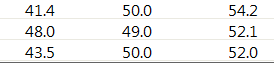

In [1112]:
idx=898
file=files[indices_clean[idx]]
# file=files[1124]

cropped1 = Image.open(file).crop( 
     (1530, 0, 1850, 900)
)                             #now take the slice of the image that we read before

cropped_top_left=cropped1.crop(
    (corner1[idx][0]-70,
     corner1[idx][1],
     corner3[idx][0]-100,
     corner3[idx][1]+362)
) #now take coords from top left and bot right to crop,so corner 1 and corner 3 for the left column

cropped_top_right=cropped1.crop(
    (corner1[idx][0]+150,
     corner1[idx][1],
     corner3[idx][0]+110,
     corner3[idx][1]+362)
) #now take coords from top left and bot right to crop,so corner 1 and corner 3 for the right column


cropped_bottom=cropped1.crop(
    (corner1[idx][0]-70,
     corner1[idx][1]+405,
     corner3[idx][0]+110,
     corner3[idx][1]+450)
) #now take coords from top left and bot right to crop,so corner 1 and corner 3 for the bottom box

cropped_bottom

In [1115]:
ocr_tess=pytesseract.image_to_string(cropped_bottom,config ='--psm 6')
ocr_tess=ocr_tess.replace('.','').replace(',','').replace('S','5')
lst_tess=ocr_tess.replace('\x0c','').split('\n')[:-1]
lst_tess=flatten([elem.split() for elem in lst_tess])
lst_tess=[elem[0:2]+'.'+elem[2:]  if isfloat(elem) else elem for elem in lst_tess]
lst_tess
# ocr_tess

['41.4', '50.0', '54.2', '48.0', '49.0', '52.1', '43.5', '50.0', '52.0']

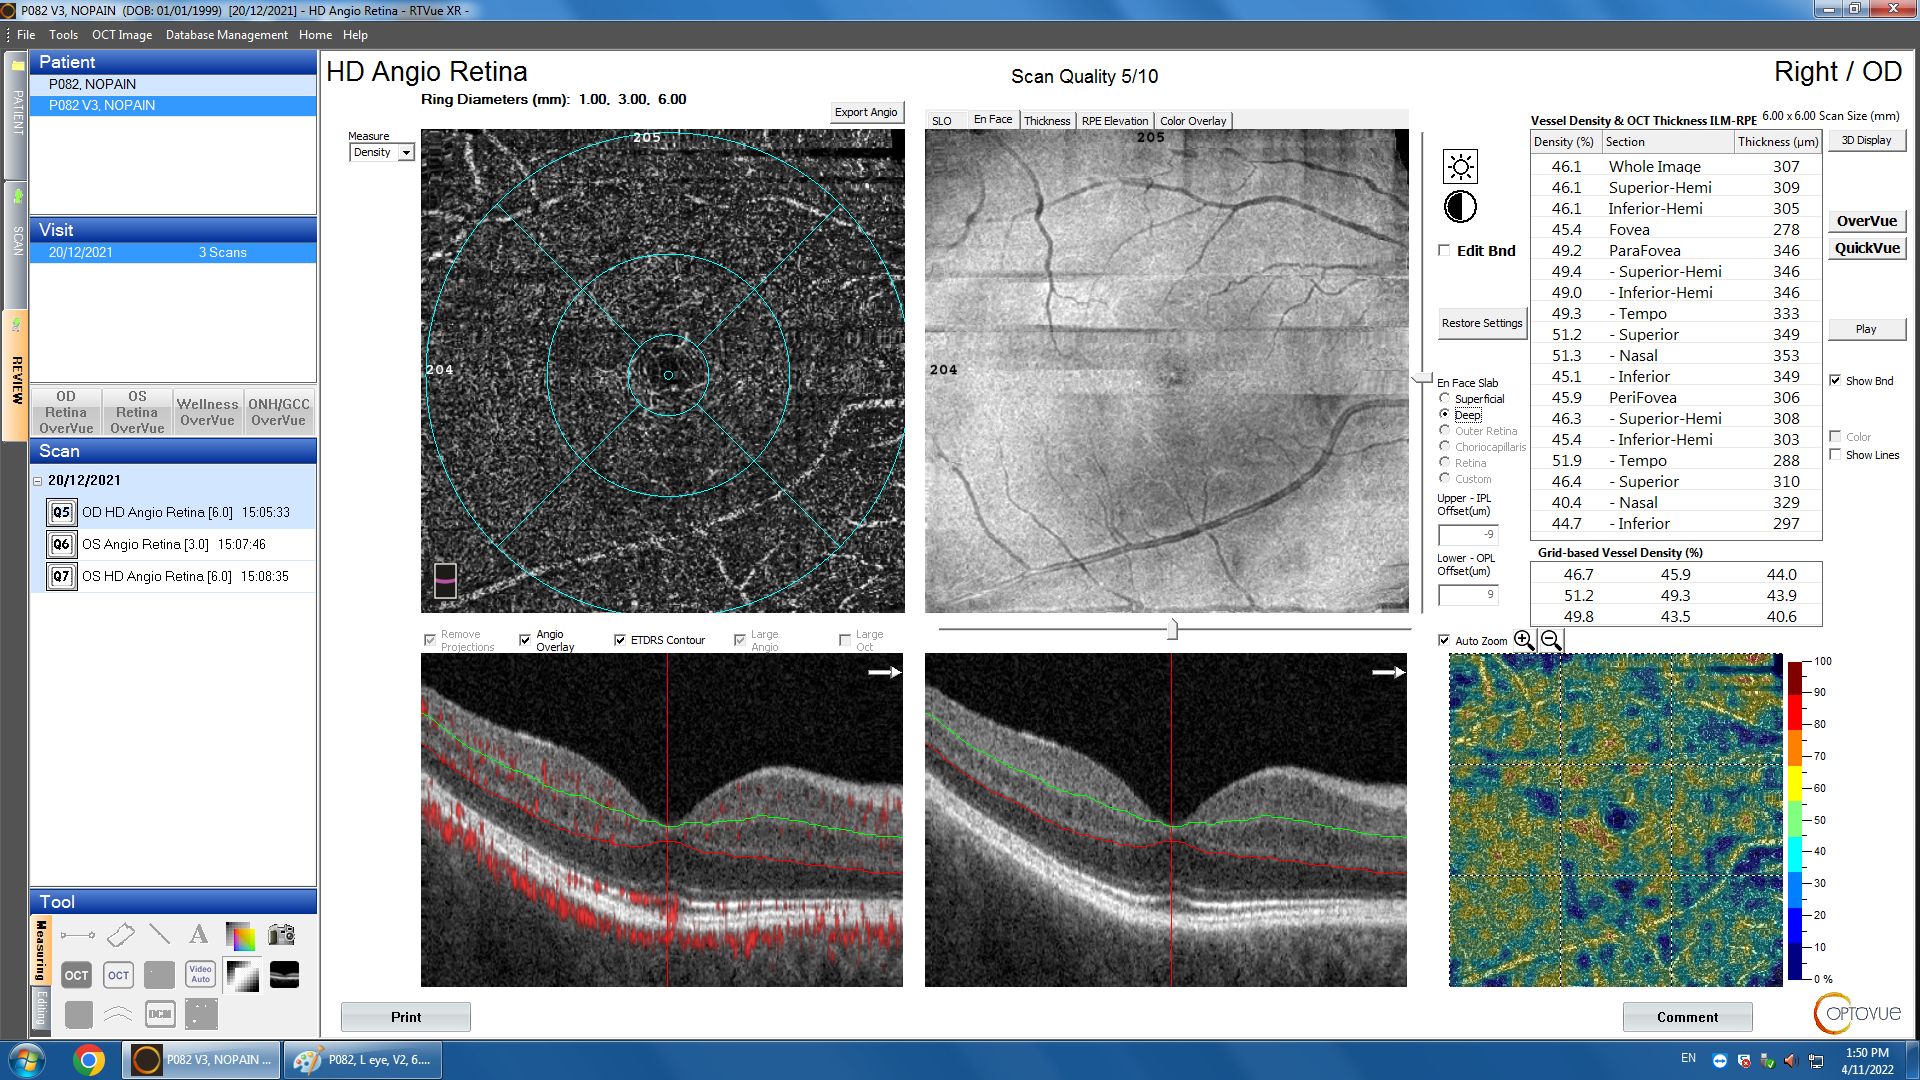

In [887]:
file=files[idx_dens[idx]]
Image.open(file)

In [1114]:
corner3[898]

[173, 409]

In [1092]:
a=reader.readtext(np.array(cropped_top_left))
a

[([[11, 0], [45, 0], [45, 17], [11, 17]], '44.5', 0.6796038436024079),
 ([[11, 19], [45, 19], [45, 37], [11, 37]], '45.2', 0.9883830502725194),
 ([[13, 43], [45, 43], [45, 59], [13, 59]], '43.9', 0.8287767012096587),
 ([[11, 61], [45, 61], [45, 81], [11, 81]], '25.8', 0.9996064305305481),
 ([[11, 83], [45, 83], [45, 101], [11, 101]], '47.0', 0.993278443813324),
 ([[11, 103], [45, 103], [45, 121], [11, 121]], '47.5', 0.8823998536370009),
 ([[11, 123], [45, 123], [45, 143], [11, 143]], '464', 0.5132871211132293),
 ([[11, 145], [45, 145], [45, 163], [11, 163]], '44.9', 0.9521714448928833),
 ([[11, 165], [45, 165], [45, 185], [11, 185]], '47.7', 0.6785983177577994),
 ([[11, 187], [45, 187], [45, 205], [11, 205]], '48.2', 0.9911966928226368),
 ([[11, 207], [43, 207], [43, 227], [11, 227]], '47.1', 0.9964085221290588),
 ([[12, 226], [44, 226], [44, 250], [12, 250]], 'NJA', 0.5190388486631855),
 ([[13, 249], [43, 249], [43, 269], [13, 269]], 'NJA', 0.825616946270026),
 ([[12, 268], [44, 268],

In [188]:
import pytesseract
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False
# Use tesseract to correct values
im=cv2.imread('evaluate/cropped.png')
ocr_tess=pytesseract.image_to_string(im,config='digits')
ocr_tess=ocr_tess.replace('.','')
lst_tess=ocr_tess.replace('\x0c','').split('\n')[:-1]
lst_tess=[elem[0:2]+'.'+elem[2:]  if isfloat(elem) else elem for elem in lst_tess]
lst_tess,len(lst_tess)

(['58.8',
  '57.6',
  '60.0',
  '39.1',
  '61.5',
  '62.3',
  '60.7',
  '60.7',
  '63.2',
  '62.1',
  '60.1',
  '61.9',
  '60.9',
  '62.9',
  '63.0',
  '60.7',
  '60.9',
  '63.0'],
 18)

# FAZ 

In [15]:
#FIND ONLY FAZ
idx_faz=[]
for i,file in enumerate(files):
    if 'FAZ' in file:
        print(i,file)
        idx_faz.append(i)

2 ../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 3.0 - FAZ.png
5 ../data/NOPAIN_OCTA/P001/V2/P001, L eye, V2, 6.0 - FAZ.png
8 ../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 3.0 - FAZ.png
11 ../data/NOPAIN_OCTA/P001/V2/P001, R eye, V2, 6.0 - FAZ.png
14 ../data/NOPAIN_OCTA/P001/V3/P001, R eye, V3, 3.0 - FAZ.png
17 ../data/NOPAIN_OCTA/P001/V3/P001, R eye, V3, 6.0 - FAZ.png
20 ../data/NOPAIN_OCTA/P002/V2/P002, L eye, V2, 3.0 - FAZ.png
23 ../data/NOPAIN_OCTA/P002/V2/P002, R eye, V2, 3.0 - FAZ.png
26 ../data/NOPAIN_OCTA/P002/V2/P002, R eye, V2, 6.0 - FAZ.png
29 ../data/NOPAIN_OCTA/P002/V3/P002, L eye, V3, 3.0 - FAZ.png
32 ../data/NOPAIN_OCTA/P002/V3/P002, L eye, V3, 6.0 - FAZ.png
35 ../data/NOPAIN_OCTA/P002/V3/P002, R eye, V3, 3.0 - FAZ.png
38 ../data/NOPAIN_OCTA/P002/V3/P002, R eye, V3, 6.0 - FAZ.png
41 ../data/NOPAIN_OCTA/P003/V2/P003, L eye, V2, 3.0 - FAZ.png
44 ../data/NOPAIN_OCTA/P003/V2/P003, L eye, V2, 6.0 - FAZ.png
47 ../data/NOPAIN_OCTA/P003/V2/P003, R eye, V2, 3.0 - FAZ.png
50 ../data/

In [19]:
def get_box_faz(idx):
    file=files[idx]
    Image.open(file)
    cropped = Image.open(file).crop(
    (330,60,1300,500)
    )
    cropped=np.array(cropped)
    reader=easyocr.Reader(['en'])
    allimg=reader.readtext(cropped,batch_size=20,width_ths=1.5)
    box=[ allimg[line] for line in range(len(allimg)) if ('mm' in allimg[line][1]) or ('FD' in allimg[line][1]) or ('Scan Quality' in allimg[line][1]) ] 
    return idx,box

In [20]:
boxes=Parallel(n_jobs=-1)(delayed(get_box_faz)(idx)for idx in idx_faz)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

## CLEAN ERRORS

In [213]:
boxes[2]

(8,
 [([[678, 4], [832, 4], [832, 28], [678, 28]],
   'Scan Quality 8/10',
   0.6369459083742673),
  ([[91, 45], [443, 45], [443, 63], [91, 63]],
   'FAZ (mm }: 0.232.  PERIM (mm): 1.864. FD: 50.48',
   0.5563504277872001)])

In [211]:
for box in boxes:
    if len(box[1])!=2:
        print(box[0],len(box[1]))


496 3
499 3
502 3
505 3
631 3
634 3
637 3
640 3
1036 4
1039 4
1042 4
1045 4
1119 3
1122 3
1125 3


In [104]:
boxes_clean={}
for box in boxes:  
    boxes_clean[box[0]]={}
    for info in box[1]:
        if 'Scan Quality' in info[1] :
            _qual=[info[0],info[1]]
        elif 'FAZ' in info[1]:
            _faz=[info[0],info[1]]
    boxes_clean[box[0]]['qual']=_qual
    boxes_clean[box[0]]['faz']=_faz

#LENGHT ERROR CHECK
for box in boxes_clean.items():
    if len(box[1]['faz'][0])!=4: 
        print(box)
        

In [1372]:
import re
text = 'FAZ (mm }: 0.330.  PERIM (mm): 2.218. FD: 58.82'
numbers = re.findall(r'\b\d+(?:\.\d+)?\b', a)
numbers

['0.330', '2.218', '58.82']

In [105]:
for box in boxes_clean.items():
    print(box[1]['qual'][0][1])

[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[832, 4]
[

# CORNERS

In [139]:
# TAKE THE CORNERS FROM ALL BOXES FOUND BY THE OCR
corner1={}
corner2={}
corner3={}
corner4={}
for box in boxes_clean:
    corner1[box]={'qual':boxes_clean[box]['qual'][0][0],'faz':boxes_clean[box]['faz'][0][0]}   #top left
    corner2[box]={'qual':boxes_clean[box]['qual'][0][1],'faz':boxes_clean[box]['faz'][0][1]}   #top right
    corner3[box]={'qual':boxes_clean[box]['qual'][0][2],'faz':boxes_clean[box]['faz'][0][2]}      #bot right
    corner4[box]={'qual':boxes_clean[box]['qual'][0][3],'faz':boxes_clean[box]['faz'][0][3]}       #bot left

In [161]:
boxes_clean.keys()

dict_keys([2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98, 101, 104, 107, 110, 113, 116, 119, 122, 125, 128, 131, 134, 137, 140, 143, 146, 149, 152, 155, 158, 161, 164, 167, 170, 173, 176, 179, 182, 185, 188, 191, 194, 197, 200, 203, 206, 209, 212, 215, 218, 221, 224, 227, 230, 241, 244, 247, 250, 253, 256, 259, 262, 265, 268, 271, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 301, 304, 307, 310, 313, 316, 319, 322, 337, 340, 343, 346, 349, 352, 355, 358, 361, 364, 367, 370, 373, 376, 379, 382, 385, 388, 391, 394, 397, 400, 403, 406, 409, 412, 415, 418, 421, 424, 427, 430, 433, 436, 439, 442, 445, 448, 451, 454, 457, 460, 463, 466, 469, 472, 475, 479, 482, 496, 499, 502, 505, 508, 511, 514, 517, 520, 523, 526, 529, 532, 535, 538, 541, 543, 545, 547, 549, 552, 554, 556, 559, 562, 565, 568, 571, 574, 577, 580, 583, 586, 589, 592, 595, 598, 601, 604, 607, 610, 613, 616, 619, 622, 625, 628, 

In [123]:
len(corner1)

222

In [114]:
for box in list(boxes_clean.items())[:2]:
    print(box[0])

2
5


In [168]:
idx=625
cropped1 = Image.open(files[idx]).crop( 
     (330,60,1300,500)
    )
cropped_faz=cropped1.crop(
        (corner1[idx]['faz'][0],
         corner1[idx]['faz'][1],
         corner3[idx]['faz'][0],
         corner3[idx]['faz'][1])
    )
cropped_qual=cropped1.crop(
        (corner1[idx]['qual'][0],
         corner1[idx]['qual'][1],
         corner3[idx]['qual'][0],
         corner3[idx]['qual'][1])
    )
display(cropped_faz)
display(cropped_qual)

# CROP AND READ

In [170]:
import tqdm

In [202]:
faz_data={}
errors={}
for box in boxes_clean:

    errors[box]={}
 
    cropped1 = Image.open(files[box]).crop( 
     (330,60,1300,500)
    )                            
    
#####FAZ
    cropped_faz=cropped1.crop(
        (corner1[box]['faz'][0],
         corner1[box]['faz'][1],
         corner3[box]['faz'][0],
         corner3[box]['faz'][1])
    )
    
    ocr_tess_faz=pytesseract.image_to_string(cropped_faz,config ='--psm 6')
    lst_tess_faz=re.findall(r'\b\d+(?:\.\d+)?\b', ocr_tess_faz)
    #check for errors
    if len(lst_tess_faz) !=3 :
        lst_tess_faz=re.findall(r'\bN/A\b', errors[227]['faz'])
        if len(lst_tess_faz) !=3:
            errors[box]['faz']=ocr_tess_faz
        
######QUALITY
    cropped_qual=cropped1.crop(
            (corner1[box]['qual'][0],
             corner1[box]['qual'][1],
             corner3[box]['qual'][0],
             corner3[box]['qual'][1])
    )

    ocr_tess_qual=pytesseract.image_to_string(cropped_qual,config ='--psm 6')
    tess_qual=extract_score(ocr_tess_qual)[0]
   
   
    if not isfloat(tess_qual) :
        errors[box]['qual']=ocr_tess_qual
        
    
    faz_data[box]={
        'faz':lst_tess_faz,
        'qual':tess_qual,
        }

In [207]:
errors

{2: {},
 5: {},
 8: {},
 11: {},
 14: {},
 17: {},
 20: {},
 23: {},
 26: {},
 29: {},
 32: {},
 35: {},
 38: {},
 41: {},
 44: {},
 47: {},
 50: {},
 53: {},
 56: {},
 59: {},
 62: {},
 65: {},
 68: {},
 71: {},
 74: {},
 77: {},
 80: {},
 83: {},
 86: {},
 89: {},
 92: {},
 95: {},
 98: {},
 101: {},
 104: {},
 107: {},
 110: {},
 113: {},
 116: {},
 119: {},
 122: {},
 125: {},
 128: {},
 131: {},
 134: {},
 137: {},
 140: {},
 143: {},
 146: {},
 149: {},
 152: {},
 155: {},
 158: {},
 161: {},
 164: {},
 167: {},
 170: {},
 173: {},
 176: {},
 179: {},
 182: {},
 185: {},
 188: {},
 191: {},
 194: {},
 197: {},
 200: {},
 203: {},
 206: {},
 209: {},
 212: {},
 215: {},
 218: {},
 221: {},
 224: {},
 227: {'faz': 'FAZ (mm*): N/A. PERIM (mm): N/A. FD: N/A\n\x0c'},
 230: {},
 241: {},
 244: {},
 247: {},
 250: {},
 253: {},
 256: {},
 259: {},
 262: {},
 265: {},
 268: {},
 271: {},
 274: {},
 276: {},
 278: {},
 280: {},
 282: {},
 284: {},
 286: {},
 288: {},
 290: {},
 292: {},
 

In [195]:
import re

def extract_score(text):
    match = re.search(r'(\d+)/(\d+)', text)
    if match:
        return match.group(0)
    return None

text = "Scan Quality aaaa 9/10"
re.findall(r'(\d+)/(\d+)', text)
# print(extract_score(text)[0])

[('9', '10')]

In [194]:
text = ocr_tess_faz
numbers = re.findall(r'\b\d+(?:\.\d+)?\b', text)
numbers

['0.238', '1.900', '54.17']

In [269]:
def get_box_densities(idx):
    file=files[idx]
    Image.open(file)
    cropped_dens = Image.open(file).crop(
    (1530, 0, 1850, 900)
    )
    cropped=np.array(cropped_dens)
    reader=easyocr.Reader(['en'])
    ocr_dens=reader.readtext(cropped,batch_size=20)
    
    
    
    box=[ ocr_dens[line] for line in range(len(ocr_dens)) if 'Whole' in ocr_dens[line][1] ] 
    return idx,box

def get_dens_qualities(idx):
    file=files[idx]
    cropped_qual = Image.open(file).crop(
    (900, 0, 1250, 650)
    )
    cropped=np.array(cropped_qual)
    reader=easyocr.Reader(['en'])
    ocr_qual=reader.readtext(cropped,batch_size=20)
    qual_elem=[elem for elem in ocr_qual if 'Scan' in elem[1]][-1][1] #-q is if it has more
    qual_value=extract_score(qual_elem)[0]
    return idx,qual_value
    
    

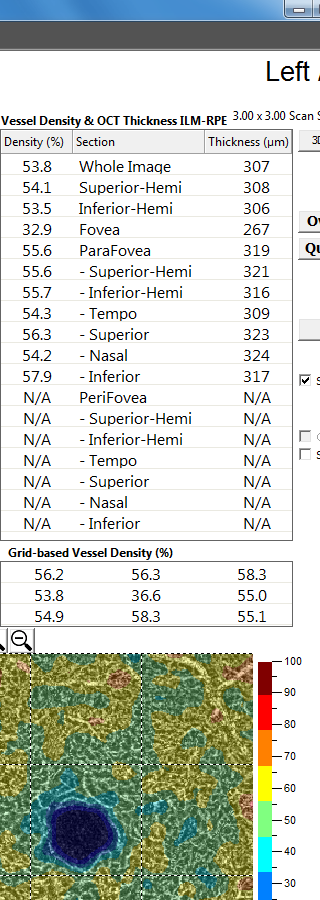

In [268]:
file=files[0]
Image.open(file)
cropped_qual = Image.open(file).crop(
(900, 0, 1250, 650)
)
cropped_qual
# cropped=np.array(cropped_qual)
# reader=easyocr.Reader(['en'])
# ocr_qual=reader.readtext(cropped,batch_size=20)
    

In [270]:
boxes=Parallel(n_jobs=-1)(delayed(get_dens_qualities)(idx)for idx in idx_dens[0:50])


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

In [271]:
boxes

[(0, '8'),
 (1, '8'),
 (3, '8'),
 (4, '8'),
 (6, '8'),
 (7, '8'),
 (9, '9'),
 (10, '9'),
 (12, '8'),
 (13, '8'),
 (15, '8'),
 (16, '8'),
 (18, '9'),
 (19, '9'),
 (21, '9'),
 (22, '9'),
 (24, '9'),
 (25, '9'),
 (27, '9'),
 (28, '9'),
 (30, '9'),
 (31, '9'),
 (33, '9'),
 (34, '9'),
 (36, '9'),
 (37, '9'),
 (39, '6'),
 (40, '6'),
 (42, '5'),
 (43, '5'),
 (45, '8'),
 (46, '8'),
 (48, '8'),
 (49, '8'),
 (51, '9'),
 (52, '9'),
 (54, '8'),
 (55, '8'),
 (57, '9'),
 (58, '9'),
 (60, '9'),
 (61, '9'),
 (63, '7'),
 (64, '7'),
 (66, '6'),
 (67, '6'),
 (69, '8'),
 (70, '8'),
 (72, '8'),
 (73, '8')]

## CLEAN DF

In [64]:
df=pd.concat(temp_to_200,ignore_index=True,)
df=df.sort_values('pat')
df
# for col in df.columns:
#     try:
#         df[col]=df[col].str.replace(",",".",)
#         df[col]=df[col].str.replace("\.\.",".",)
#         df=df.replace('NJA',np.nan)
#         df=df.replace('N/A',np.nan)
        
#     except:
#         pass
# df

,pat,v,eye,depth,QUALITY,depth_whole,depth_sup hemi,depth_inf hemi,depth_fovea,depth_parafovea,...,grid_v_d4,grid_v_d5,grid_v_d6,grid_v_d7,grid_v_d8,grid_v_d9,area (mm2),perim (mm),FD,specification
0,P001,V2,L eye,3.0,8/10,53.8,54.1,53.5,32.9,55.6,...,53.8,36.6,55.0,54.9,58.3,55.1,NaN,NaN,NaN,DP
1,P001,V2,L eye,3.0,8/10,"46,0",46.0,46.1,153,49.9,...,48.8,23.1,48.8,49.9,49.9,47.0,NaN,NaN,NaN,SUP
2,P001,V2,L eye,3.0,8/10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.272,2110,49.05,FAZ
3,P001,V2,L eye,6.0,8/10,553,54.2,56.44,"43,4",573,...,52.8,54.7,50.7,57.1,"56,4","54,9",NaN,NaN,NaN,DP
4,P001,V2,L eye,6.0,8/10,47.9,48.3,47.5,25.0,50.6,...,49.5,46.7,46.5,53.0,"46,0",43.2,NaN,NaN,NaN,SUP
5,P001,V2,L eye,6.0,8/10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.238,1.900,54.17,FAZ
6,P001,V2,R eye,3.0,8/10,"55,9",55.9,"55,9",36.6,57.2,...,554,39.7,56.2,58.5,58.1,58.7,NaN,NaN,NaN,DP
7,P001,V2,R eye,3.0,8/10,473,47.4,473,20.6,50.2,...,47.7,27.0,48.1,474,51.0,52.2,NaN,NaN,NaN,SUP
8,P001,V2,R eye,3.0,8/10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.232,1.864,50.48,FAZ
9,P001,V2,R eye,6.0,9/10,52.0,50.5,53.6,41.7,54.1,...,56.3,52.2,52.0,56.2,54.3,49.44,NaN,NaN,NaN,DP


In [ ]:
df.pat.value_counts()
df.specification.value_counts()
idx=df[df.specification=='DP'].pat.value_counts().index.values
df[df.specification=='DP'].pat.value_counts()

In [ ]:
len([file for file in files[:200] if 'SUP' in file])
len([file for file in files[:200] if 'DP' in file])
# len([file for file in files[:200] if 'FAZ' in file])
[file for file in files[:200] if 'DP' in file]

for i in idx:
    print(i,[file.split('/')[3] for file in files[:200] if 'DP' in file].count(i))

In [ ]:
df[(df.pat=='P009') & (df.v=='V3')& (df.specification=='DP') ][['pat','v','depth','specification','eye']]

In [ ]:
vs=[]
for elem in temp_to_200[123:135]:
    try:
        vs.append([elem.v.values[0],elem.depth.values[0],elem.eye.values[0],elem.specification.values[0]])
    except:
        pass
vs

In [ ]:
files[123:135]
extract(files[126])
# files[126]

In [ ]:
from IPython.display import Image
Image(filename='/home/ubuntu/Eyes/notebooks/evaluate/P009_V3_L eye_6.01a27298e-9e86-4f26-8aeb-6de1b61730fc/c_cropped_quality.png')

In [ ]:
errors_bot

# PIVOT DF

In [ ]:
#kinda works but ugly 
# df.iloc[0].fillna('')+df.iloc[1].fillna('')

#THIS IS THE SOLUTION. NP.NAN != NP.NAN , WHEREAS EVERYTHING ELSE == TO ITSELF. THEREFORE I USE THAT TO DISCRIMINATE
s='DP' #AGGREGATE EVERYTHING THAT IS NOT DP, so really SP
df_pivot_sup=pd.pivot_table(
    df[(df.specification!=s)],
    index=["pat",'v','depth','eye'],
    aggfunc=lambda x: x.iloc[0] if(x.iloc[0]==x.iloc[0] ) or (len(x)==1) else x.iloc[1]
              )
df_pivot_sup=df_pivot_sup.apply(pd.to_numeric,errors='ignore')
df_pivot_sup=df_pivot_sup.drop(['specification'],axis=1)

s='SUP' #AGGREGATE EVERYTHING THAT IS NOT DP, so really SP
df_pivot_dp=pd.pivot_table(
    df[(df.specification!=s)],
    index=["pat",'v','depth','eye'],
    aggfunc=lambda x: x.iloc[0] if(x.iloc[0]==x.iloc[0] ) or (len(x)==1) else x.iloc[1]
              )
df_pivot_dp=df_pivot_dp.apply(pd.to_numeric,errors='ignore')
df_pivot_dp=df_pivot_dp.drop(['specification'],axis=1)

In [ ]:
df_pivot_sup.to_csv('df_pivot_SUP.csv')
df_pivot_dp.to_csv('df_pivot_DP.csv')

## OUTLIERS

In [ ]:
# df[df.specification=='SU']
df.specification.unique()

In [ ]:
from scipy import stats

# df_pivot[(np.abs(stats.zscore(df_pivot.drop(['QUALITY', 'specification'],axis=1))) > 3).any(axis=1)]
dfn=df_pivot.drop(['QUALITY', 'specification'],axis=1)
cols=dfn.columns
fin=[]
for col in cols:
    zscore=stats.zscore(dfn[col]) > 3
    if zscore.any():
#         fin.append([col,zscore[zscore==True].index])
        fin.append([col,df_pivot.loc[zscore[zscore==True].index]])

In [ ]:
i=10
print(fin[i][1].index,fin[i][0])
df_pivot.loc[fin[i][1].index]

In [ ]:
pd.set_option('display.max_columns', 60)

# DF COLLATION

## FAZ V2 &V3

In [ ]:
cols=['QUALITY','area (mm2)','perim (mm)','FD']

a_faz_v2=df_pivot_dp.xs('V2',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=lambda x:x).xs('L eye',level=1,axis=1
                                                                 ).xs('3.0',level=1,axis=1)[cols]
b_faz_v2=df_pivot_dp.xs('V2',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=lambda x:x).xs('L eye',level=1,axis=1
                                                                 ).xs('6.0',level=1,axis=1)[cols]
c_faz_v2=df_pivot_dp.xs('V2',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=lambda x:x).xs('R eye',level=1,axis=1
                                                                 ).xs('3.0',level=1,axis=1)[cols]
d_faz_v2=df_pivot_dp.xs('V2',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=lambda x:x).xs('R eye',level=1,axis=1
                                                                 ).xs('6.0',level=1,axis=1)[cols]
faz_v2=pd.concat([a_faz_v2,b_faz_v2,c_faz_v2,d_faz_v2],axis=1)
faz_v2=faz_v2.reset_index()
faz_v2

a_faz_v3=df_pivot_dp.xs('V3',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=lambda x:x).xs('L eye',level=1,axis=1
                                                                 ).xs('3.0',level=1,axis=1)[cols]
b_faz_v3=df_pivot_dp.xs('V3',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=lambda x:x).xs('L eye',level=1,axis=1
                                                                 ).xs('6.0',level=1,axis=1)[cols]
c_faz_v3=df_pivot_dp.xs('V3',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=lambda x:x).xs('R eye',level=1,axis=1
                                                                 ).xs('3.0',level=1,axis=1)[cols]
d_faz_v3=df_pivot_dp.xs('V3',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=lambda x:x).xs('R eye',level=1,axis=1
                                                                 ).xs('6.0',level=1,axis=1)[cols]
faz_v3=pd.concat([a_faz_v3,b_faz_v3,c_faz_v3,d_faz_v3],axis=1)
faz_v3=faz_v3.reset_index()
faz_v3

# DENSITY DP DATA

In [ ]:
cols=[
 'QUALITY',
 'depth_whole',
 'depth_sup hemi',
 'depth_inf hemi',
 'depth_fovea',
 'depth_parafovea',
 'depth_para_sup hemi',
 'depth_parai_inf hemi',
 'depth_para temp',
 'depth_para_sup',
 'depth_para_nasal',
 'depth_para_inf',
 'depth_perifovea',
 'depth_peri_sup hemi',
 'depth_peri_inf hemi',
 'depth_peri_tempo ',
 'depth_peri_sup',
 'depth_peri_nasal',
 'depth_peri_inf',
 'thick_whole',
 'thick_sup hemi',
 'thick_inf hemi',
 'thick_fovea',
 'thick_parafovea',
 'thick_para_sup hemi',
 'thick_parai_inf hemi',
 'thick_para temp',
 'thick_para_sup',
 'thick_para_nasal',
 'thick_para_inf',
 'thick_perifovea',
 'thick_peri_sup hemi',
 'thick_peri_inf hemi',
 'thick_peri_tempo ',
 'thick_peri_sup',
 'thick_peri_nasal',
 'thick_peri_inf',
 'grid_v_d1',
 'grid_v_d2',
 'grid_v_d3',
 'grid_v_d4',
 'grid_v_d5',
 'grid_v_d6',
 'grid_v_d7',
 'grid_v_d8',
 'grid_v_d9',
]

## V2

In [ ]:
dp_v2_piv=df_pivot_dp[cols].xs('V2',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=list )

dp_v2_piv=dp_v2_piv.applymap(lambda x: x[0] if type(x)==list else x)

a_dp_v2=dp_v2_piv.xs('L eye',level=1,axis=1).xs('3.0',level=1,axis=1)
b_dp_v2=dp_v2_piv.xs('L eye',level=1,axis=1).xs('6.0',level=1,axis=1)
c_dp_v2=dp_v2_piv.xs('R eye',level=1,axis=1).xs('3.0',level=1,axis=1)
d_dp_v2=dp_v2_piv.xs('R eye',level=1,axis=1).xs('6.0',level=1,axis=1)
dp_v2=pd.concat([a_dp_v2[cols],b_dp_v2[cols],c_dp_v2[cols],d_dp_v2[cols]],axis=1)
dp_v2=dp_v2.reset_index()
dp_v2

## V3

In [ ]:
dp_v3_piv=df_pivot_dp[cols].xs('V3',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=list )

dp_v3_piv=dp_v3_piv.applymap(lambda x: x[0] if type(x)==list else x)

a_dp_v3=dp_v3_piv.xs('L eye',level=1,axis=1).xs('3.0',level=1,axis=1)
b_dp_v3=dp_v3_piv.xs('L eye',level=1,axis=1).xs('6.0',level=1,axis=1)
c_dp_v3=dp_v3_piv.xs('R eye',level=1,axis=1).xs('3.0',level=1,axis=1)
d_dp_v3=dp_v3_piv.xs('R eye',level=1,axis=1).xs('6.0',level=1,axis=1)
dp_v3=pd.concat([a_dp_v3[cols],b_dp_v3[cols],c_dp_v3[cols],d_dp_v3[cols]],axis=1)
dp_v3=dp_v3.reset_index()
dp_v3

# DENSITY SUP

## V2

In [ ]:
sup_v2_piv=df_pivot_sup[cols].xs('V2',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=list )

sup_v2_piv=sup_v2_piv.applymap(lambda x: x[0] if type(x)==list else x)

a_sup_v2=sup_v2_piv.xs('L eye',level=1,axis=1).xs('3.0',level=1,axis=1)
b_sup_v2=sup_v2_piv.xs('L eye',level=1,axis=1).xs('6.0',level=1,axis=1)
c_sup_v2=sup_v2_piv.xs('R eye',level=1,axis=1).xs('3.0',level=1,axis=1)
d_sup_v2=sup_v2_piv.xs('R eye',level=1,axis=1).xs('6.0',level=1,axis=1)
sup_v2=pd.concat([a_sup_v2[cols],b_sup_v2[cols],c_sup_v2[cols],d_sup_v2[cols]],axis=1)
sup_v2=sup_v2.reset_index()
sup_v2

## V3

In [ ]:
sup_v3_piv=df_pivot_sup[cols].xs('V3',level=1).pivot_table(index='pat',
                                           columns=['eye','depth'],
                                           aggfunc=list )

sup_v3_piv=sup_v3_piv.applymap(lambda x: x[0] if type(x)==list else x)

a_sup_v3=sup_v3_piv.xs('L eye',level=1,axis=1).xs('3.0',level=1,axis=1)
b_sup_v3=sup_v3_piv.xs('L eye',level=1,axis=1).xs('6.0',level=1,axis=1)
c_sup_v3=sup_v3_piv.xs('R eye',level=1,axis=1).xs('3.0',level=1,axis=1)
d_sup_v3=sup_v3_piv.xs('R eye',level=1,axis=1).xs('6.0',level=1,axis=1)
sup_v3=pd.concat([a_sup_v3[cols],b_sup_v3[cols],c_sup_v3[cols],d_sup_v3[cols]],axis=1)
sup_v3=sup_v3.reset_index()
sup_v3

## ALL COLLATED V2

In [ ]:
collated_v2=pd.concat([
    a_sup_v2,a_dp_v2,a_faz_v2,
    b_sup_v2,b_dp_v2,b_faz_v2,
    c_sup_v2,c_dp_v2,c_faz_v2,
    d_sup_v2,d_dp_v2,d_faz_v2,
                      ],axis=1,)
collated_v2=collated_v2.reset_index()
collated_v2

## ALL COLLATED V3

In [ ]:
collated_v3=pd.concat([
    a_sup_v3,a_dp_v3,a_faz_v3,
    b_sup_v3,b_dp_v3,b_faz_v3,
    c_sup_v3,c_dp_v3,c_faz_v3,
    d_sup_v3,d_dp_v3,d_faz_v3,
                      
                      ],axis=1,)
collated_v3=collated_v3.reset_index()
collated_v3

# EXCEL FILLING 

In [1]:
from openpyxl.utils.dataframe import dataframe_to_rows
wb=op.load_workbook('../data/OCTA_final/NOPAIN TRIAL OCTA DATA EXTRACTION.xlsx')

NameError: name 'op' is not defined

In [ ]:
sheet_names=wb.sheetnames
sheet_names

# WRITING

In [ ]:
###################################################################### V2_COLLATED
wb.active=wb['V2 COLLATED']
ws=wb.active
rows = dataframe_to_rows(collated_v2,index=False,header=False)
for r_idx, row in enumerate(rows, 4):
    for c_idx, value in enumerate(row, 1):
         ws.cell(row=r_idx, column=c_idx, value=value)
###################################################################### V3_COLLATED
wb.active=wb['V3 COLLATED']
ws=wb.active
rows = dataframe_to_rows(collated_v3,index=False,header=False)
for r_idx, row in enumerate(rows, 4):
    for c_idx, value in enumerate(row, 1):
         ws.cell(row=r_idx, column=c_idx, value=value)
            
###################################################################### V2_DENSITY_DP
wb.active=wb[ 'V2 DENSITY DP DATA ']
ws=wb.active
rows = dataframe_to_rows(dp_v2,index=False,header=False)
for r_idx, row in enumerate(rows, 4):
    for c_idx, value in enumerate(row, 1):
         ws.cell(row=r_idx, column=c_idx, value=value)

###################################################################### V3_DENSITY_DP
wb.active=wb[ 'V3 DENSITY DP DATA']
ws=wb.active
rows = dataframe_to_rows(dp_v3,index=False,header=False)
for r_idx, row in enumerate(rows, 4):
    for c_idx, value in enumerate(row, 1):
         ws.cell(row=r_idx, column=c_idx, value=value)
###################################################################### V2_DENSITY_SUP
wb.active=wb[ 'V2 DENSITY SUP DATA']
ws=wb.active
rows = dataframe_to_rows(sup_v2,index=False,header=False)
for r_idx, row in enumerate(rows, 4):
    for c_idx, value in enumerate(row, 1):
         ws.cell(row=r_idx, column=c_idx, value=value)
###################################################################### V3_DENSITY_SUP
wb.active=wb[ 'V3 DENSITY SUP DATA']
ws=wb.active
rows = dataframe_to_rows(sup_v3,index=False,header=False)
for r_idx, row in enumerate(rows, 4):
    for c_idx, value in enumerate(row, 1):
         ws.cell(row=r_idx, column=c_idx, value=value)
            
###################################################################### V2_FAZ
wb.active=wb[ 'V2 FAZ']
ws=wb.active
rows = dataframe_to_rows(faz_v2,index=False,header=False)
for r_idx, row in enumerate(rows, 4):
    for c_idx, value in enumerate(row, 1):
         ws.cell(row=r_idx, column=c_idx, value=value)
###################################################################### V3_FAZ
wb.active=wb[ 'V3 FAZ']
ws=wb.active
rows = dataframe_to_rows(faz_v3,index=False,header=False)
for r_idx, row in enumerate(rows, 4):
    for c_idx, value in enumerate(row, 1):
         ws.cell(row=r_idx, column=c_idx, value=value)


In [3]:
wb.save("OCTA_EXTRACTION_FILLED_FINAL.xlsx")

NameError: name 'wb' is not defined

In [4]:
wb

NameError: name 'wb' is not defined